In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-2025-04-14")
# llm.invoke("Hi")

In [3]:
import sys
sys.setrecursionlimit(1500)  # Set the recursion limit to 1500

In [4]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph,START,END
from langchain_community.tools import DuckDuckGoSearchRun
from typing import Annotated


In [5]:
import os
from langchain_community.tools import TavilySearchResults
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
search_tool = TavilySearchResults(tavily_api_key = TAVILY_API_KEY)
# search_tool.invoke("Who is the first PM of India")

/var/folders/d0/hjzx7_6d2xd0kf3ygxpprztw0000gn/T/ipykernel_19906/1570417993.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(tavily_api_key = TAVILY_API_KEY)


In [6]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
/var/folders/d0/hjzx7_6d2xd0kf3ygxpprztw0000gn/T/ipykernel_19906/1459227625.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/var/folders/d0/hjzx7_6d2xd0kf3ygxpprztw0000gn/T/ipykernel_19906/1459227625.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [7]:
def make_system_prompt(instruction:str) -> str:
    return(
        """You are a helpful AI assistant,collaborating with other assistants.
        Use the provided tools to progress towards answering the question
        If you are unable to fully answer,that's OK,another assistant with different tools 
        will help you where you left off.Execute what you can too make progress
        If you or any of the other assistants have the final answer or deliverable prefix your response with FINAL ANSWER so that team knows to stop"""
        f"\n{instruction}"
    )
make_system_prompt("You can only do research.You are working with a chart generator colleague ")

"You are a helpful AI assistant,collaborating with other assistants.\n        Use the provided tools to progress towards answering the question\n        If you are unable to fully answer,that's OK,another assistant with different tools \n        will help you where you left off.Execute what you can too make progress\n        If you or any of the other assistants have the final answer or deliverable prefix your response with FINAL ANSWER so that team knows to stop\nYou can only do research.You are working with a chart generator colleague "

In [8]:
from langchain_core.messages import BaseMessage,HumanMessage
def get_next_node(last_message:BaseMessage,goto:str):
    if "FINAL_ANSWER" in last_message.content:
        #Any agent decided the work is done
        return END
    return goto

In [9]:
# agent1
def research_node(state:MessagesState) -> Command[Literal["chart_generator",END]]:
    research_agent = create_react_agent(
        llm,
        tools=[search_tool],
        prompt= make_system_prompt(
            "You can only do research. You are working with a chart generator colleague"
        ),
    )
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content,name="researcher")
    return Command(update={"messages":result["messages"]},goto=goto)

In [10]:
#agent 2 
def chart_node(state:MessagesState) -> Command[Literal["researcher",END]]:
    chart_agent = create_react_agent(
        llm,
        tools = [python_repl_tool],
        prompt= make_system_prompt(
            "You can only generate charts.You are working with a researcher colleague"
        ),
    )
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content,name="chart_generator")
    return Command(update={"messages":result["messages"]},goto=goto)


In [11]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_edge(START,"researcher")
app = workflow.compile()

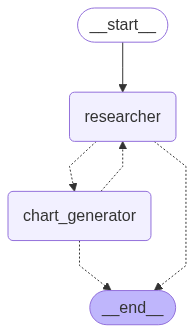

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
pip install langchain langchain-openai langchain-community langchain-experimental langgraph tavily-python python-dotenv matplotlib pandas numpy seaborn

Note: you may need to restart the kernel to use updated packages.


Testing search tool...
Search tool works!
Testing REPL...
REPL works!
Running workflow for: show me top 10 most populated countries with a bar chart


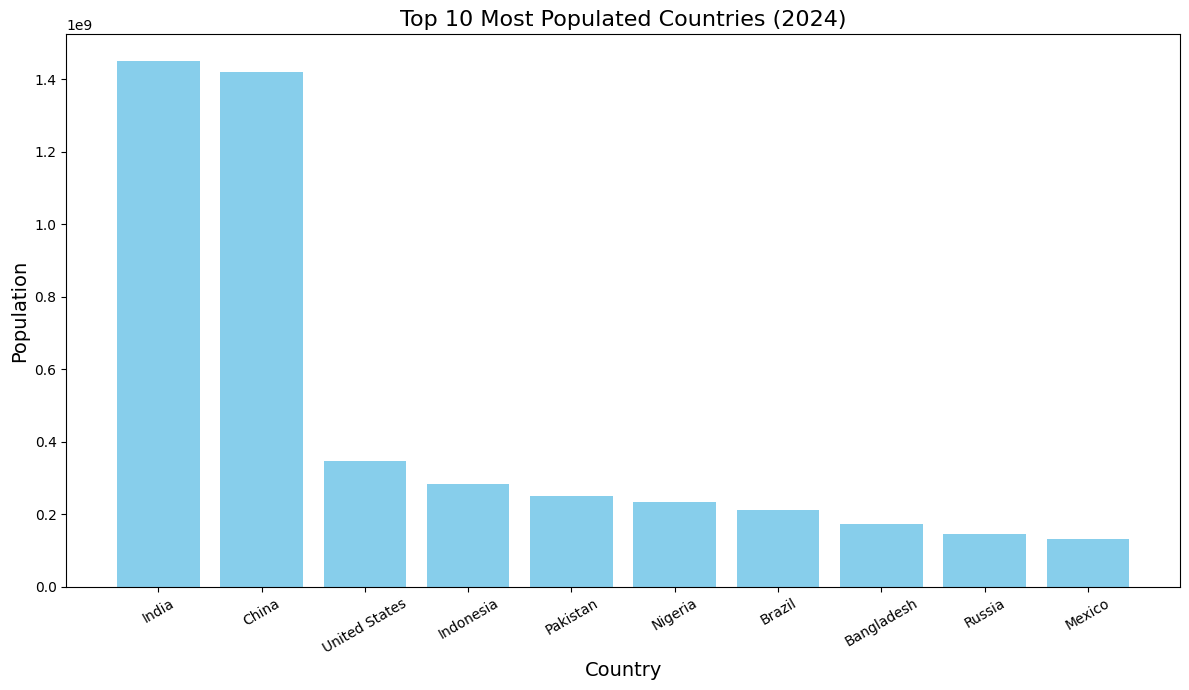


Workflow completed!

Conversation flow:

[USER]: show me top 10 most populated countries with a bar chart

[TAVILY_SEARCH_RESULTS_JSON]:
[{"title": "Top 10 Most Populated Nations of the World (2025)", "url": "https://www.jagranjosh.com/general-knowledge/top-ten-most-populated-nations-of-the-world-1393925211-1", "content": "Image 4: Most populated nations of the World 2024\n\nMost populated nations of the World 2024\n\nAccording to re...

[RESEARCHER]:
Here are the top 10 most populated countries in 2024, according to several trusted sources including the World Population Review and CIA World Factbook, with their estimated populations:

1. India: 1,450,935,791
2. China: 1,419,321,278
3. United States: 345,426,571
4. Indonesia: 283,487,931
5. Pakis...

[PYTHON_REPL_TOOL]:
Successfully executed:
```python
import matplotlib.pyplot as plt
import pandas as pd

# Data
countries = ['India', 'China', 'United States', 'Indonesia', 'Pakistan', 'Nigeria', 'Brazil', 'Bangladesh', 'Russia', 'Mexico

In [2]:
# Import required packages
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-2025-04-14")

# Core LangGraph imports
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated

# Search tools
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults

# Python REPL
from langchain_experimental.utilities import PythonREPL

# Set up search tool
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if TAVILY_API_KEY:
    search_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
else:
    search_tool = DuckDuckGoSearchRun()

# Set up Python REPL
repl = PythonREPL()

# Test the tools (optional)
print("Testing search tool...")
try:
    search_result = search_tool.invoke("who is the current pm of uk?")
    print("Search tool works!")
except Exception as e:
    print(f"Search tool error: {e}")

print("Testing REPL...")
test_code = """
x = 5
y = x * 2
print(f"Result: {y}")
"""
try:
    repl_result = repl.run(test_code)
    print("REPL works!")
except Exception as e:
    print(f"REPL error: {e}")

# Define Python REPL tool
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# System prompt function
def make_system_prompt(instruction: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

# Node routing function
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

# Agent 1: Research Node
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    research_agent = create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
            """You can only do research. You are working with a chart generator colleague.
            Your job is to:
            1. Search for the requested data
            2. Gather specific numerical data, statistics, or information needed
            3. Present the data in a clear, structured format
            4. Do NOT attempt to create charts yourself
            
            When you have sufficient data, clearly indicate that your chart_generator 
            colleague should take over to create the visualization."""
        ), 
    )
    
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, 
        name="researcher"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

# Agent 2: Chart Generator Node
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    chart_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
            """You can only generate charts. You are working with a researcher colleague.
            Your job is to:
            1. Take the data provided by the researcher
            2. Create the requested visualization using matplotlib
            3. Use proper labels, titles, and formatting
            4. Once the chart is created successfully, respond with FINAL ANSWER
            
            Available libraries: matplotlib, pandas, numpy, seaborn
            Always include plt.show() to display the chart.
            
            Do NOT search for additional data - use what the researcher provided."""
        ),
    )
    
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, 
        name="chart_generator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

# Build the workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")

# Compile the workflow
app = workflow.compile()

# Function to run the workflow
def run_workflow(query: str, recursion_limit: int = 15):
    """Run the multi-agent workflow with the given query."""
    config = {"recursion_limit": recursion_limit}
    
    print(f"Running workflow for: {query}")
    print("=" * 60)
    
    try:
        result = app.invoke(
            {"messages": [("user", query)]},
            config=config
        )
        
        print("\n" + "=" * 60)
        print("Workflow completed!")
        print("\nConversation flow:")
        
        for i, msg in enumerate(result["messages"]):
            if hasattr(msg, 'name') and msg.name:
                print(f"\n[{msg.name.upper()}]:")
                # Truncate long messages for readability
                content = msg.content[:300] + "..." if len(msg.content) > 300 else msg.content
                print(content)
            elif i == 0:
                print(f"\n[USER]: {msg.content}")
        
        return result
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Test with IPL cricket data
    query = "show me top 10 most populated countries with a bar chart"
    
    # Run the workflow
    result = run_workflow(query)
    
    # You can also try other queries:
    # run_workflow("what is uk's gdp in past 3 years, draw line chart")
    # run_workflow("show me top 10 most populated countries with a bar chart")
    # run_workflow("create a line chart of bitcoin price trend in last 6 months")

In [3]:
import streamlit as st
import os
from dotenv import load_dotenv
import io
import sys
from contextlib import redirect_stdout, redirect_stderr

# Load environment variables
load_dotenv()

# Import required packages
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL

# Page configuration
st.set_page_config(
    page_title="AI Research & Chart Generator",
    page_icon="📊",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown("""
<style>
    .main-header {
        text-align: center;
        padding: 1rem 0;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
    .chat-message {
        padding: 1rem;
        border-radius: 10px;
        margin: 1rem 0;
        border-left: 4px solid #667eea;
    }
    .researcher-message {
        background-color: #f0f8ff;
        border-left-color: #4CAF50;
    }
    .chart-generator-message {
        background-color: #fff5f5;
        border-left-color: #FF6B6B;
    }
    .user-message {
        background-color: #f9f9f9;
        border-left-color: #667eea;
    }
</style>
""", unsafe_allow_html=True)

# Initialize session state
if 'workflow_result' not in st.session_state:
    st.session_state.workflow_result = None
if 'chart_generated' not in st.session_state:
    st.session_state.chart_generated = False

@st.cache_resource
def initialize_workflow():
    """Initialize the workflow with proper configuration."""
    
    # Get API keys from environment or Streamlit secrets
    openai_api_key = os.getenv("OPENAI_API_KEY") or st.secrets.get("OPENAI_API_KEY", "")
    tavily_api_key = os.getenv("TAVILY_API_KEY") or st.secrets.get("TAVILY_API_KEY", "")
    
    if not openai_api_key:
        st.error("❌ OpenAI API key not found! Please add it in Streamlit secrets or .env file")
        st.stop()
    
    # Set up LLM
    llm = ChatOpenAI(
        model="gpt-4.1-2025-04-14",
        api_key=openai_api_key,
        temperature=0.1
    )
    
    # Set up search tool
    if tavily_api_key:
        search_tool = TavilySearchResults(tavily_api_key=tavily_api_key)
    else:
        search_tool = DuckDuckGoSearchRun()
    
    # Set up Python REPL
    repl = PythonREPL()
    
    # Define Python REPL tool
    @tool
    def python_repl_tool(
        code: Annotated[str, "The python code to execute to generate your chart."],
    ):
        """Use this to execute python code. If you want to see the output of a value,
        you should print it out with `print(...)`. This is visible to the user."""
        
        # Capture output
        stdout_capture = io.StringIO()
        stderr_capture = io.StringIO()
        
        try:
            # Enhanced code with matplotlib backend for Streamlit
            enhanced_code = f"""
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure for better display
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

{code}

# Save the plot if created
import matplotlib.pyplot as plt
if plt.get_fignums():
    plt.savefig('generated_chart.png', bbox_inches='tight', dpi=150)
    print("Chart saved successfully!")
"""
            
            with redirect_stdout(stdout_capture), redirect_stderr(stderr_capture):
                result = repl.run(enhanced_code)
            
            stdout_output = stdout_capture.getvalue()
            stderr_output = stderr_capture.getvalue()
            
            # Check if chart was created
            import matplotlib.pyplot as plt
            if plt.get_fignums():
                st.session_state.chart_generated = True
                # Display the chart in Streamlit
                st.pyplot(plt.gcf())
                plt.close('all')  # Clean up
            
            output = f"Execution successful!\n"
            if stdout_output:
                output += f"Output: {stdout_output}\n"
            if stderr_output:
                output += f"Warnings: {stderr_output}\n"
                
            return output + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
            
        except Exception as e:
            return f"Failed to execute. Error: {repr(e)}"
    
    # System prompt function
    def make_system_prompt(instruction: str) -> str:
        return (
            "You are a helpful AI assistant, collaborating with other assistants."
            " Use the provided tools to progress towards answering the question."
            " If you are unable to fully answer, that's OK, another assistant with different tools "
            " will help where you left off. Execute what you can to make progress."
            " If you or any of the other assistants have the final answer or deliverable,"
            " prefix your response with FINAL ANSWER so the team knows to stop."
            f"\n{instruction}"
        )
    
    # Node routing function
    def get_next_node(last_message: BaseMessage, goto: str):
        if "FINAL ANSWER" in last_message.content:
            return END
        return goto
    
    # Agent 1: Research Node
    def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
        research_agent = create_react_agent(
            llm,
            tools=[search_tool],
            prompt=make_system_prompt(
                """You can only do research. You are working with a chart generator colleague.
                Your job is to:
                1. Search for the requested data
                2. Gather specific numerical data, statistics, or information needed
                3. Present the data in a clear, structured format
                4. Do NOT attempt to create charts yourself
                
                When you have sufficient data, clearly indicate that your chart_generator 
                colleague should take over to create the visualization."""
            ), 
        )
        
        result = research_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "chart_generator")
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, 
            name="researcher"
        )
        return Command(update={"messages": result["messages"]}, goto=goto)
    
    # Agent 2: Chart Generator Node
    def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
        chart_agent = create_react_agent(
            llm,
            tools=[python_repl_tool],
            prompt=make_system_prompt(
                """You can only generate charts. You are working with a researcher colleague.
                Your job is to:
                1. Take the data provided by the researcher
                2. Create the requested visualization using matplotlib
                3. Use proper labels, titles, and formatting
                4. Once the chart is created successfully, respond with FINAL ANSWER
                
                Available libraries: matplotlib, pandas, numpy, seaborn
                Always include plt.show() to display the chart.
                
                Do NOT search for additional data - use what the researcher provided."""
            ),
        )
        
        result = chart_agent.invoke(state)
        goto = get_next_node(result["messages"][-1], "researcher")
        result["messages"][-1] = HumanMessage(
            content=result["messages"][-1].content, 
            name="chart_generator"
        )
        return Command(update={"messages": result["messages"]}, goto=goto)
    
    # Build the workflow
    workflow = StateGraph(MessagesState)
    workflow.add_node("researcher", research_node)
    workflow.add_node("chart_generator", chart_node)
    workflow.add_edge(START, "researcher")
    
    # Compile the workflow
    app = workflow.compile()
    
    return app

def display_conversation(messages):
    """Display the conversation in a nice format."""
    for i, msg in enumerate(messages):
        if hasattr(msg, 'name') and msg.name:
            if msg.name == "researcher":
                st.markdown(f"""
                <div class="chat-message researcher-message">
                    <strong>🔍 RESEARCHER:</strong><br>
                    {msg.content}
                </div>
                """, unsafe_allow_html=True)
            elif msg.name == "chart_generator":
                st.markdown(f"""
                <div class="chat-message chart-generator-message">
                    <strong>📊 CHART GENERATOR:</strong><br>
                    {msg.content}
                </div>
                """, unsafe_allow_html=True)
        elif i == 0:  # User message
            st.markdown(f"""
            <div class="chat-message user-message">
                <strong>👤 USER:</strong><br>
                {msg.content}
            </div>
            """, unsafe_allow_html=True)

# Main app
def main():
    # Header
    st.markdown("""
    <div class="main-header">
        <h1>🤖 AI Research & Chart Generator</h1>
        <p>Multi-Agent System for Intelligent Data Research and Visualization</p>
    </div>
    """, unsafe_allow_html=True)
    
    # Sidebar
    with st.sidebar:
        st.header("📋 How it works")
        st.markdown("""
        1. **🔍 Research Agent**: Searches for data online
        2. **📊 Chart Generator**: Creates visualizations
        3. **🤝 Collaboration**: Agents work together seamlessly
        """)
        
        st.header("💡 Example Queries")
        example_queries = [
            "Show me top 10 most populated countries with a bar chart",
            "What is UK's GDP in past 3 years, draw line chart",
            "Create a line chart of Bitcoin price trend in last 6 months",
            "IPL winners in last 5 years with their final match scores",
            "Global temperature trends in last decade visualization"
        ]
        
        for query in example_queries:
            if st.button(f"📝 {query[:30]}...", key=query, use_container_width=True):
                st.session_state.selected_query = query
    
    # Initialize workflow
    try:
        app = initialize_workflow()
        st.success("✅ Multi-Agent System Initialized Successfully!")
    except Exception as e:
        st.error(f"❌ Failed to initialize: {str(e)}")
        st.stop()
    
    # Main input
    col1, col2 = st.columns([4, 1])
    
    with col1:
        user_query = st.text_input(
            "🎯 What would you like to research and visualize?",
            value=st.session_state.get('selected_query', ''),
            placeholder="e.g., Show me top 10 most populated countries with a bar chart"
        )
    
    with col2:
        recursion_limit = st.number_input("Max Steps", min_value=5, max_value=25, value=15)
    
    # Generate button
    if st.button("🚀 Generate Research & Chart", type="primary", use_container_width=True):
        if user_query:
            st.session_state.chart_generated = False
            
            with st.spinner("🤖 Agents are working together..."):
                try:
                    config = {"recursion_limit": recursion_limit}
                    result = app.invoke(
                        {"messages": [("user", user_query)]},
                        config=config
                    )
                    st.session_state.workflow_result = result
                    
                except Exception as e:
                    st.error(f"❌ Error during execution: {str(e)}")
                    st.exception(e)
        else:
            st.warning("⚠️ Please enter a query!")
    
    # Display results
    if st.session_state.workflow_result:
        st.header("🗣️ Agent Conversation")
        
        with st.expander("View Full Conversation", expanded=True):
            display_conversation(st.session_state.workflow_result["messages"])
        
        # Success message
        if st.session_state.chart_generated:
            st.success("🎉 Chart generated successfully! Check above for the visualization.")
        
        # Download option
        if st.session_state.chart_generated:
            try:
                with open("generated_chart.png", "rb") as file:
                    st.download_button(
                        label="📥 Download Chart",
                        data=file.read(),
                        file_name="ai_generated_chart.png",
                        mime="image/png"
                    )
            except FileNotFoundError:
                pass

if __name__ == "__main__":
    main()

2025-06-29 22:04:56.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-29 22:04:56.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar